In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
from shapely.geometry import Point
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from descartes.patch import PolygonPatch
from mpl_toolkits.basemap import Basemap

pd.set_option('display.max_columns', None)

In [2]:
def gpd_read_csv(filename):
    df = pd.read_csv(filename)
    df['geometry'] = df.geometry.map(shapely.wkt.loads)
    return gpd.GeoDataFrame(df)

parcels = gpd_read_csv('output/parcels.csv').set_index('ParcelNo', drop=False)

In [3]:
def get_nearest(p, n=5, df=parcels):
    if hasattr(p, 'total_bounds'):
        bounds = p.total_bounds
    elif hasattr(p, 'bounds'):
        bounds = p.bounds
    else:
        bounds = p
    hits = list(df.sindex.nearest(bounds, n))
    return df.iloc[hits]

In [4]:
def plot_parcels(data):
    legend_data = {}

    def plot(data=None, label=None, color=None, **kwargs):
        pc = PatchCollection(data.geometry.map(PolygonPatch), facecolor=color, alpha=0.7)
        plt.gca().add_collection(pc)
        legend_data[label] = Line2D(
            [0], [0], linestyle="none",
            marker="o", alpha=1, markersize=10,
            markerfacecolor=color, label=label,
        )

    g = sns.FacetGrid(data, hue='IsBlighted', size=10)
    g.map_dataframe(plot)

    # add_legend does not work correctly for some reason.
    #g.add_legend(legend_data=legend_data)
    g.axes.flat[0].legend(handles=list(legend_data.values()), scatterpoints=1)

    lon_min, lat_min, lon_max, lat_max = data.total_bounds
    m = Basemap(
        epsg=4326,
        llcrnrlat=lat_min,
        urcrnrlat=lat_max,
        llcrnrlon=lon_min,
        urcrnrlon=lon_max,
        ax=g.ax,
    )
    m.arcgisimage(service='World_Topo_Map', xpixels=1000, verbose=True)
    
#plot_parcels(get_nearest(parcels.iloc[333].geometry, n=100))

In [5]:
violations = pd.read_csv('data/detroit-blight-violations.csv')
violations = violations.join(violations.ViolationAddress.str.extract(r'\((?P<Lat>.+)?,\s*(?P<Lon>.+)?\)', expand=True).astype(float))
geometry = violations.apply(lambda row: Point(row.Lon, row.Lat), axis=1)
violations = gpd.GeoDataFrame(violations, geometry=geometry, crs={'init': 'epsg:4326'})

/workspace/conda/envs/ds/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
violations.head()

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,MailingZipCode,NonUsAddressCode,Country,TicketIssuedDT,TicketIssuedTime,HearingDT,CourtTime,ViolationCode,ViolDescription,Disposition,FineAmt,AdminFee,LateFee,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress,Lat,Lon,geometry
0,26288,05000001DAH,Department of Public Works,"Group, LLC, Grand Holding",2566,GRAND BLVD,743,"Beaubien, Ste. 201",Detroit,MI,48226,NaN,NaN,01/01/38440 12:00:00 AM,12:00:00,01/01/38474 12:00:00 AM,9:00AM,22-2-20,Burning solid waste in open fires,Responsible By Determination,$1500.00,$20.00,$150.00,$10.00,$0.00,$1680.00,PAID IN FULL,0.0,0,"2566 GRAND BLVD\nDetroit, MI\n(42.363182370000...","743 Beaubien\nDetroit, MI 48226\n(42.333730630...",42.363182,-83.091677,POINT (-83.09167672099994 42.36318237000006)
1,19800,05000025DAH,Department of Public Works,"JACKSON, RAECHELLE",19014,ASHTON,20501,HEYDEN,DETROIT,MI,48219,NaN,NaN,01/01/38383 12:00:00 AM,10:15:00,01/01/38425 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Not responsible By Determination,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"19014 ASHTON\nDetroit, MI\n(42.429390762000025...","20501 HEYDEN\nDETROIT, MI 48219\n(42.442177633...",42.429391,-83.220394,POINT (-83.22039357799997 42.42939076200003)
2,19804,05000026DAH,Department of Public Works,"TALTON, CAROL ANN",18735,STAHELIN,18735,STAHELI N,DETROIT,MI,48219,NaN,NaN,01/01/38383 12:00:00 AM,10:35:00,01/01/38425 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Responsible By Determination,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"18735 STAHELIN\nDetroit, MI\n(42.4287074590000...","18735 STAHELI N\nDETROIT, MI 48219\n(42.428707...",42.428707,-83.227548,POINT (-83.22754809599996 42.42870745900007)
3,20208,05000027DAH,Department of Public Works,"BONNER, DARRYL E.",20125,MONICA,25335,PEEKSKILL,SOUTHFIELD,MI,48043,NaN,NaN,01/01/38385 12:00:00 AM,10:45:00,01/01/38422 12:00:00 AM,1:30PM,22-2-45,Violation of time limit for approved container...,Responsible By Default,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"20125 MONICA\nDetroit, MI\n(42.44169828400004,...","25335 PEEKSKILL\nSOUTHFIELD, MI 48043\n(42.475...",42.441698,-83.145018,POINT (-83.14501821599998 42.44169828400004)
4,20211,05000028DAH,Department of Public Works,"GREGORY, JAMES LEE",17397,PRAIRIE,17397,PRAIRIE,DETROIT,MI,48221,NaN,NaN,01/01/38385 12:00:00 AM,11:10:00,01/01/38422 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Responsible By Default,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"17397 PRAIRIE\nDetroit, MI\n(42.42031769500005...","17397 PRAIRIE\nDETROIT, MI 48221\n(42.42031769...",42.420318,-83.145328,POINT (-83.14532817999998 42.42031769500005)


/workspace/conda/envs/ds/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


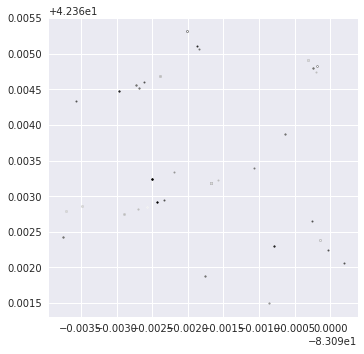

In [7]:
get_nearest(violations.iloc[0].geometry, n=100, df=violations).plot()

In [8]:
def get_parcel_no_fast(p):
    hit = next(parcels.sindex.nearest(p.bounds, 1))
    return parcels.iloc[hit].ParcelNo

def get_parcel_no_precise(p, n=10):
    hits = list(parcels.sindex.nearest(p.bounds, n))
    distances = parcels.iloc[hits].distance(p)
    return distances.argmin()

In [9]:
def plot_sample(sample):
    def plot(points, label=None, color=None, **kwargs):
        ax = plt.gca()
        gpd.GeoSeries(points).plot(ax=ax, color=color, markersize=8)
        parcels.loc[[label]].plot(ax=ax, color=color)

    g = sns.FacetGrid(sample, hue='NearestParcelNo', size=10)
    g.map(plot, 'geometry')
    g.add_legend()

    ax = g.ax

    lon_min, lon_max = ax.get_xlim()
    lat_min, lat_max = ax.get_ylim()

    lon_mid = (lon_min + lon_max) / 2
    lat_mid = (lat_min + lat_max) / 2
    get_nearest((lon_mid, lat_mid, lon_mid, lat_mid), n=200).plot(ax=ax, alpha=0)

    m = Basemap(
        epsg=4326,
        llcrnrlon=lon_min,
        urcrnrlon=lon_max,
        llcrnrlat=lat_min,
        urcrnrlat=lat_max,
        ax=ax,
    )
    m.arcgisimage(service='World_Topo_Map', xpixels=1000, verbose=True)

#sample = get_nearest(violations.iloc[1].geometry, 100, df=violations).copy()
#sample['NearestParcelNo'] = sample.apply(lambda row: get_parcel_no_precise(row.geometry), axis=1)
#plot_sample(sample)

In [10]:
#pd.merge(parcels, sample.NearestParcelNo.value_counts().reset_index(name='NumViolations'), left_index=True, right_on='index')

In [11]:
def get_df():
    left = pd.DataFrame({'Data': np.random.randn(1000000)})
    left['Key'] = np.random.permutation(left.index)
    return left

left = get_df()
right = get_df()
left_index = left.set_index('Key', drop=False)
right_index = right.set_index('Key', drop=False)

def test_join():
    left.join(right, how='inner', on='Key', rsuffix='r')

def test_join_index():
    left_index.join(right_index, how='inner', rsuffix='r')

def test_key():
    pd.merge(left, right, on='Key')

def test_index():
    pd.merge(left_index, right_index, left_index=True, right_index=True)

def test_index_key():
    pd.merge(left_index, right, left_index=True, right_on='Key')

def test_key_index():
    pd.merge(left, right_index, right_index=True, left_on='Key')

%timeit test_key()
%timeit test_index()
%timeit test_key_index()
%timeit test_index_key()
%timeit test_join()
%timeit test_join_index()

1 loop, best of 3: 378 ms per loop
1 loop, best of 3: 159 ms per loop
1 loop, best of 3: 396 ms per loop
1 loop, best of 3: 402 ms per loop
1 loop, best of 3: 386 ms per loop
10 loops, best of 3: 229 ms per loop


In [12]:
%%time
num_violations = violations.geometry.map(get_parcel_no_fast).value_counts().to_frame(name='NumViolations')

In [13]:
parcels = pd.merge(parcels, num_violations, how='left', left_index=True, right_index=True)

In [14]:
parcels.NumViolations = parcels.NumViolations.fillna(0).astype(int)

In [15]:
parcels.drop('geometry', axis=1).to_csv('output/parcels_num_violations.csv', index=False)